In [1]:
import datetime

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from gymnasium import spaces
from gymnasium.wrappers import RecordVideo

# Only work with scipy 1.12.0
# https://discourse.pymc.io/t/importerror-cannot-import-name-gaussian-from-scipy-signal/14170/3
from scipy.signal import convolve, gaussian

from T02_prototype_class.DE_IM_VRPTW_class2 import VRPTW

In [2]:
class MetaEnv(gym.Env):
    def __init__(self, vrp, interval_it=100):
        # order = [
        #     "best_solution",
        #     "F",
        #     "CR",
        #     "MG",
        #     "percent_convergence",
        #     "std_pop",
        #     "count_total_iteration",
        # ]

        self.observation_space = gym.spaces.Box(
            low=np.array([-2, 0, 0, 0, 0, 0, 0], dtype=np.float64),
            high=np.array([2, 10, 10, 1, 1, 1, 1e5], dtype=np.float64),
            shape=(7,),  # 7 features
            dtype=np.float64,
        )

        # self.observation_space = spaces.Dict(
        #     # TODO: Check bounds
        #     {
        #         "best_solution": gym.spaces.Box(
        #             low=0, high=1e6, shape=(1,), dtype=np.float64
        #         ),
        #         "F": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float64),
        #         "CR": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float64),
        #         "MG": gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float64),
        #         "percent_convergence": gym.spaces.Box(
        #             low=0, high=10, shape=(1,), dtype=np.float64
        #         ),
        #         "count_total_iteration": gym.spaces.Box(
        #             low=0, high=1e5, shape=(1,), dtype=np.int64
        #         ),
        #         "std_pop": gym.spaces.Box(low=0, high=10, shape=(1,), dtype=np.float64),
        #         # "DE_robust": gym.spaces.Box(
        #         #     low=0, high=1, shape=(1,), dtype=np.float64
        #         # ),
        #     }
        # )

        self.action_space = gym.spaces.Discrete(13)
        self.vrp = vrp
        self.interval_it = interval_it

    def _get_obs(self):
        """Convert internal state to observation format.

        Returns:
            dict: Observation
        """
        state = self.vrp.get_current_state()

        obs = np.array(
            [
                np.float64(state["best_solution"]),
                np.float64(state["F"]),
                np.float64(state["CR"]),
                np.float64(state["MG"]),
                np.float64(state["percent_convergence"]),
                np.float64(state["std_pop"]),
                np.float64(state["count_total_iteration"]),
            ],
            dtype=np.float64,
        )

        # obs = {
        #     "best_solution": np.array([raw_obs["best_solution"]], dtype=np.float64),
        #     "F": np.array([raw_obs["F"]], dtype=np.float64),
        #     "CR": np.array([raw_obs["CR"]], dtype=np.float64),
        #     "MG": np.array([raw_obs["MG"]], dtype=np.float64),
        #     "percent_convergence": np.array(
        #         [raw_obs["percent_convergence"]], dtype=np.float64
        #     ),
        #     "std_pop": np.array([raw_obs["std_pop"]], dtype=np.float64),
        #     "count_total_iteration": np.array(
        #         [raw_obs["count_total_iteration"]], dtype=np.int64
        #     ),
        #     # "DE_robust": np.array([raw_obs["DE_robust"]], dtype=np.float64) if needed
        # }
        return obs

    def _get_info(self):
        # TODO: We might want to see more stuff here.
        """Compute auxiliary information for debugging.

        Returns:
            dict: Info in addition to the observation
        """
        return {**self.vrp.get_current_state()}

    def reset(self, seed=None, options=None, **kwargs):
        self.vrp.reset()
        super().reset(seed=seed)
        np.random.seed(seed or 42)
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        # Expect action to be a number between 0 and 12
        actionMap = {
            0: "F0CR0",
            1: "F+CR0",
            2: "F-CR0",
            3: "F0CR+",
            4: "F0CR-",
            5: "F+CR+",
            6: "F+CR-",
            7: "F-CR+",
            8: "F-CR-",
            9: "MG0",
            10: "MG10",
            11: "MG25",
            12: "MG50",
        }
        # Check action and action map
        if actionMap.get(action) is None:
            raise Exception("Invalid action")
        self.vrp.action(actionMap[action])
        self.vrp.evolve(n_iteration=self.interval_it)

        reward = self.vrp.get_reward()
        if self.vrp.is_terminated():
            terminated = True
            truncated = True
        else:
            terminated = False
            truncated = False
        observation = self._get_obs()
        info = self._get_info()
        return observation, reward, terminated, truncated, info

In [3]:
MetaEnv(vrp=None).observation_space.sample()

array([1.44471745e+00, 4.40695707e+00, 9.73328501e+00, 9.67081194e-01,
       2.50059986e-01, 1.92147467e-01, 4.82604587e+04])

In [4]:
# Load CSV file
distance = (
    pd.read_csv(
        r"../Source/solomon_data/solomon25_csv/distance_matrix/c101distanceMatrix.csv"
    )
    .fillna(9999999)
    .to_numpy()
)

df_vehicle = (
    pd.read_csv(r"../Source/solomon_data/solomon25_csv/data_info/c101dataInfo.csv")
    .iloc[:, :2]
    .to_numpy(dtype=int)
)
vehicle = df_vehicle[0]

df_101 = pd.read_csv(
    r"../Source/solomon_data/solomon25_csv/customers/c101customers.csv"
).iloc[:, 3:]
demand = df_101.iloc[:, 0].to_numpy()
readyTime = df_101.iloc[:, 1].to_numpy()
dueDate = df_101.iloc[:, 2].to_numpy()
serviceTime = df_101.iloc[:, -1].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}

dimensions = len(distance) - 1 + vehicle[0]
interval_it = 20
max_iteration = 100
population_size = 100
bounds = np.array([[0, 1]] * dimensions)
F_rate = 0.5
CR_rate = 0.5
MG_rate = 0.5


vrp = VRPTW(
    population_size=population_size,
    dimensions=dimensions,
    bounds=bounds,
    distance=distance,
    demand=demand,
    readyTime=readyTime,
    dueDate=dueDate,
    serviceTime=serviceTime,
    vehicle=vehicle,
    percent_convergence_lookback_it=interval_it,
    solution_scale_factor=700,
    max_iteration=max_iteration
)

In [5]:
vrp.reset()
vrp.get_current_state()
# vrp.evolve(n_iteration=10)

{'F': 0.500005,
 'CR': 0.500005,
 'MG': 0.5,
 'best_solution': 0.9115615814592475,
 'percent_convergence': 0,
 'std_pop': 1,
 'count_total_iteration': 0}

In [6]:
# TODO: Fix the environment to pass the checks
# UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
#   logger.warn(f"{pre} is not within the observation space.")
# Environment has issues: Deterministic step observations are not equivalent for the same seed and action


from gymnasium.utils.env_checker import check_env

env = MetaEnv(vrp=vrp, interval_it=interval_it)

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment has issues: shape mismatch: value array of shape (0,50) could not be broadcast to indexing result of shape (10,50)


In [7]:
# env = MetaEnv(vrp=vrp, interval_it=100)

# print(env.reset(seed=4))
# print(env.action_space.sample())

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dim = 7
n_actions = 13

In [9]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.actor = nn.Linear(128, n_actions)
        self.critic = nn.Linear(128, 1)

    def forward(self, s):
        x = F.relu(self.fc1(s))
        logits = self.actor(x)
        state_value = self.critic(x)
        return logits, state_value


model = ActorCritic()
model = model.to(device)

In [10]:
def sample_action(state):
    """
    params: states: [batch, state_dim]
    returns: probs: [batch, n_actions]
    """
    state = torch.tensor(state, device=device, dtype=torch.float32)
    with torch.no_grad():
        logits, _ = model(state)
    action_probs = nn.functional.softmax(logits, -1).detach().numpy()[0]
    action = np.random.choice(n_actions, p=action_probs)
    return action

In [11]:
def generate_trajectory(env, n_steps=1000):
    """
    Play a session and genrate a trajectory
    returns: arrays of states, actions, rewards
    """
    states, actions, rewards = [], [], []

    # initialize the environment
    s, _ = env.reset()

    # generate n_steps of trajectory:
    for t in range(n_steps):
        # print(f"Trajectory step: {t}")
        # sample action based on action_probs
        a = sample_action(np.array([s]))
        next_state, r, done, _, _ = env.step(a)

        # update arrays
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = next_state
        if done:
            break

    return states, actions, rewards

In [12]:
s, _ = env.reset()
a = sample_action(np.array([s]))
a
next_state, r, done, _, _ = env.step(a)

In [13]:
def get_rewards_to_go(rewards, gamma=0.99):
    T = len(rewards)  # total number of individual rewards
    # empty array to return the rewards to go
    rewards_to_go = [0] * T
    rewards_to_go[T - 1] = rewards[T - 1]

    for i in range(T - 2, -1, -1):  # go from T-2 to 0
        rewards_to_go[i] = gamma * rewards_to_go[i + 1] + rewards[i]

    return rewards_to_go

In [14]:
# init Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train_one_episode(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    # get rewards to go
    rewards_to_go = get_rewards_to_go(rewards, gamma)

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards_to_go = torch.tensor(rewards_to_go, device=device, dtype=torch.float)

    # get action probabilities from states
    logits, state_values = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    log_probs_for_actions = log_probs[range(len(actions)), actions]

    advantage = rewards_to_go - state_values.squeeze(-1)

    # Compute loss to be minized
    J = torch.mean(log_probs_for_actions * (advantage))
    H = -(probs * log_probs).sum(-1).mean()

    loss = -(J + entropy_coef * H)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return np.sum(rewards)  # to show progress on training

In [15]:
total_steps = 10
total_rewards = []
total_actions = []

In [24]:
total_steps = 20

for i in range(total_steps):
    print(f"Step {i+1}/{total_steps}")
    states, actions, rewards = generate_trajectory(env)
    reward = train_one_episode(states, actions, rewards)
    total_rewards.append(reward)
    total_actions.append(actions)

env.close()


Step 1/20
Step 2/20
Step 3/20
Step 4/20
Step 5/20
Step 6/20
Step 7/20
Step 8/20
Step 9/20
Step 10/20
Step 11/20
Step 12/20
Step 13/20
Step 14/20
Step 15/20
Step 16/20
Step 17/20
Step 18/20
Step 19/20
Step 20/20


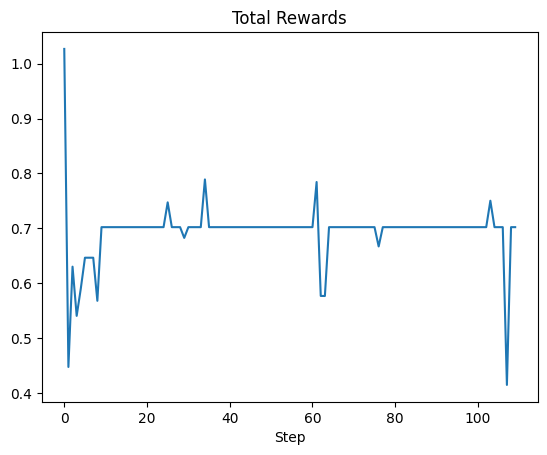

In [25]:
plt.plot(total_rewards)
plt.xlabel("Step")
plt.title("Total Rewards")
plt.show()

In [26]:
total_rewards

[1.0269467815921527,
 0.4474741473418158,
 0.6302286779020164,
 0.5405586178655745,
 0.5904939102771697,
 0.6465309051891494,
 0.6465309051891494,
 0.6465309051891494,
 0.5680025841735267,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.7473584756455127,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.6826340641046906,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.7891478911102677,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.702204491180304,
 0.70220

In [22]:
total_actions

[[4, 8, 1, 12, 12],
 [4, 7, 1, 12, 12],
 [4, 6, 1, 12, 12],
 [4, 5, 1, 12, 1],
 [4, 4, 1, 12, 1],
 [4, 1, 1, 12, 1],
 [4, 1, 1, 12, 1],
 [4, 1, 1, 12, 1],
 [4, 1, 1, 7, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 4, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 5, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 6, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],
 [4, 1, 1, 1, 1],